In [300]:
import matplotlib.pyplot as plt
import random
from matplotlib.widgets import Slider
import numpy as np
import scipy.stats as stats
from scipy.stats import norm
from ipywidgets import interact
import ipywidgets as widgets
from scipy.special import comb
from scipy.stats import binom
from scipy.special import factorial
from sklearn.linear_model import LinearRegression
from IPython.display import display, Math, Latex


A general Fokker Planck equation is given by 
$$
\partial_tu=\partial_{xx}^2(a(x, u)u)-\partial_x(b(x, u)u), \qquad u_0=\delta_x
$$
and connected with the associated McKean-Vlasov SDE
$$
dX_t=b(X_t, u_t)dt+\sqrt{2a(X_t, u_t)}dB_t, \qquad u_t=\mathcal{L}(X_t), \qquad X_0=x
$$

Consider the heat equation starting in zero
$$
\partial_tu=\frac{1}{2}\partial_{xx}^2(u), \qquad u_0=\delta_0
$$
which is typically interpreted as a Fokker Planck equation by with $a=1/2$, $b=0$. In this case, the associated SDE yields Brownian motion.  However, note that also different interpretations might be possible. 

Let $\beta\in (0, \infty)$. Note that we may write the heat equation as 
$$
\partial_tu=\frac{1}{2}\partial_{xx}^2(u)=\partial_{xx}^2\left(\frac{\beta}{2}u\right)-\partial_x\left( (1-\beta)\frac{-\partial_x u}{2u} u\right), \qquad u_0=\delta_0
$$

We interpret this as a nonlinear Fokker Planck equation, for which we have an associated McKean-Vlasov equation:
$$
dX^\beta_t=(1-\beta)\frac{-\partial_xu_t}{2u_t}(X^\beta_t)dt+\sqrt{\beta}dB_t, \qquad u_t=\mathcal{L}(X_t), \qquad X_0=0
$$
Since we know the solution to the heat equation, the above simplifies to a standard SDE
$$
dX_t^\beta=(1-\beta)\frac{X_t}{2t}dt+\sqrt{\beta}dB_t
$$

By variation of constants, the process $X^\beta$ is given by
$$X^\beta_t = \sqrt{\beta} \int_0^t (t/s)^{(1-\beta)/2} \, dB_s.$$

Observe that for $(\eta_u)_u$ a family of iid standard normals, we have
$$
\sqrt{\beta} \int_0^t (t/s)^{(1-\beta)/2} \, dB_s 
= \sqrt{\beta} \, t^{(1-\beta)/2} \sum_{[u, v] \in \mathcal{P}^n([0, t])}\int_u^v r^{(\beta-1)/2}dB_r\sim \sqrt{\beta} \, t^{(1-\beta)/2} \sum_{[u, v] \in \mathcal{P}^n([0, t])}\frac{1}{\sqrt{\beta}}(v^\beta-u^\beta)^{1/2}\eta_u
$$
We therefore discretize as follows: Given $N\in \mathbb{N}$ and the grid $\mathcal{P}^n=\{t_i=i/N\ | \ i=1, \ldots, N\}$ over $[0, 1]$, we set $X^\beta_0=0$ and compute 
$$
X^\beta_{t_i}=t_i^{(1-\beta)/2}\sum_{k\leq i}(t_k^\beta-t_{k-1}^\beta)^{1/2}\eta_k
$$
where $(\eta_i)_{i\leq N-1}$ is a sample of iid standarad normals. 

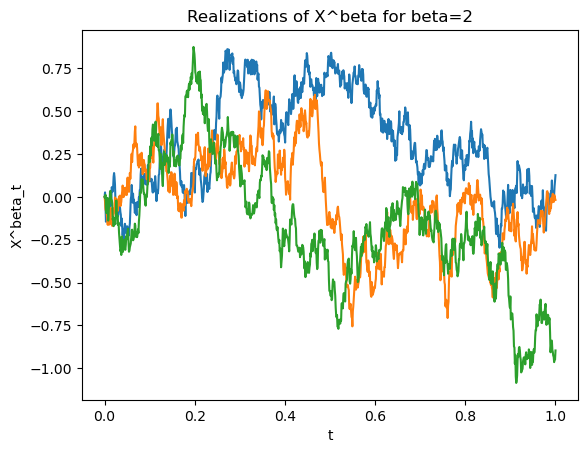

In [477]:
#Compute a realization of X along grid

def sim(beta, gridpoints):
    #All simulations on [0, 1]. 
    grid=np.linspace(0, 1, gridpoints)
    eta = np.random.normal(loc=0, scale=1, size=gridpoints)

    z=np.zeros(gridpoints-1)
    for i in range(gridpoints-1):
        z[i]=eta[i]*np.sqrt(grid[i+1]**beta-grid[i]**beta)

    x=np.zeros(gridpoints)
    for j in np.arange(1, gridpoints):
        x[j]=np.sum(z[:j])*grid[j]**((1-beta)/2)

    return x

#Plot three realizations of X
    
gridpoints=1000
beta=2
grid=np.linspace(0, 1, gridpoints)
plt.plot(grid, sim(beta, gridpoints))
plt.plot(grid, sim(beta, gridpoints))
plt.plot(grid, sim(beta, gridpoints))
plt.title(f'Realizations of X^beta for beta={beta}')
plt.xlabel('t')
plt.ylabel('X^beta_t')
#plt.savefig('beta0.01.png')
plt.show()


In [306]:
 """
For saving pictures

 
gridpoints=1000
beta=0.01
grid=np.linspace(0, 1, gridpoints)
plt.plot(grid, sim(beta, gridpoints))
plt.plot(grid, sim(beta, gridpoints))
plt.plot(grid, sim(beta, gridpoints))
plt.title(f'Realizations of X^beta for beta={beta}')
plt.xlabel('t')
plt.ylabel('X^beta_t')
plt.savefig('beta0.01.png')
plt.show()
"""

"\nFor saving pictures\n\n\ngridpoints=1000\nbeta=0.01\ngrid=np.linspace(0, 1, gridpoints)\nplt.plot(grid, sim(beta, gridpoints))\nplt.plot(grid, sim(beta, gridpoints))\nplt.plot(grid, sim(beta, gridpoints))\nplt.title(f'Realizations of X^beta for beta={beta}')\nplt.xlabel('t')\nplt.ylabel('X^beta_t')\nplt.savefig('beta0.01.png')\nplt.show()\n"

Since the marginals of $X^\beta$ are the same as Brownian motion, we know that $\mathbb{E}[(X^\beta_1)^2]=1$. Hence we can empirically compute the variance of our sample and make sure it matches.

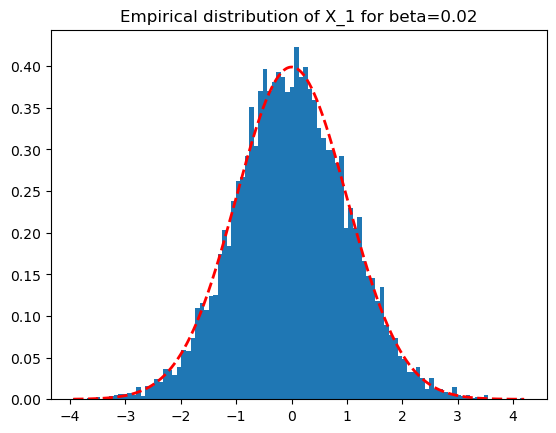

Variance of sample is 1.0193057722341992


In [309]:
#Compute empricial one points marginals at t=1 as sanity check

beta=0.02
gridpoints=1000
runs=10000
def one_time_marginals(beta, gridpoints, runs):
    final_values = []
    for _ in range(runs):
        path = sim(beta, gridpoints)
        final_values.append(path[-1])  # Value at t = 1
    return final_values

data=one_time_marginals(beta, gridpoints, runs)
var=np.var(data)
plt.hist(data, bins=100, density=True)
plt.title(f'Empirical distribution of X_1 for beta={beta}')
x_vals = np.linspace(min(data), max(data), 1000)
plt.plot(x_vals, norm.pdf(x_vals, loc=0, scale=1), 'r--', linewidth=2, label='Standard Normal')

plt.show()
print(f'Variance of sample is {var}')

We can also compute the covariance of $X^\beta$. For $s\leq t$ 
$$
\mathbb{E}[X_sX_t]=t^{(1-\beta)/2}s^{(1+\beta)/2}
$$
Setting $t=1$, we plot $\mathbb{E}[X_sX_1]$ empirically and theoretically.

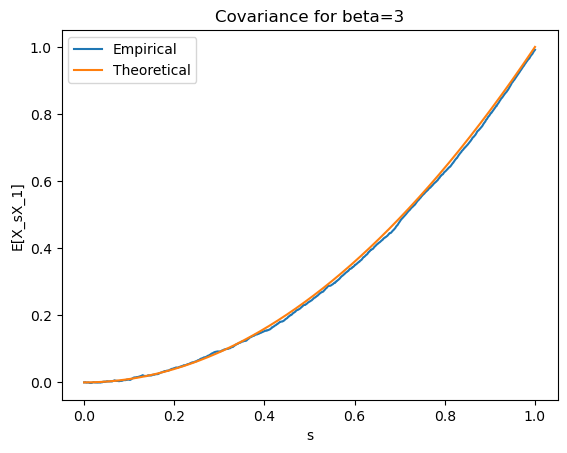

In [311]:
#Compute empricial two point correlation as sanity check

beta=3
gridpoints=1000
runs=10000
def covariance(beta, gridpoints, runs):
    cov=np.zeros(gridpoints)
    for _ in range(runs):
        path = sim(beta, gridpoints)
        for i in range(gridpoints):
            cov[i]=cov[i]+path[-1]*path[i]  # Value at t = 1
    return cov/runs

grid=np.linspace(0, 1, gridpoints)
cov_theory=grid**((1+beta)/2)
plt.plot(grid, covariance(beta, gridpoints, runs), label='Empirical')
plt.plot(grid, cov_theory, label='Theoretical')
plt.title(f'Covariance for beta={beta}')
plt.xlabel('s')
plt.ylabel('E[X_sX_1]')
plt.legend()
plt.show()

Here we are interested in one realization of Brownian motion and how it behaves under different choices of $\beta$.

In [424]:
#Here we illustrate how for a fixed realization eta, X^\beta varies in \beta.
gridpoints=1000
    #All simulations on [0, 1]. 
grid=np.linspace(0, 1, gridpoints)
samples = np.random.normal(loc=0, scale=1, size=gridpoints)


z=np.zeros(gridpoints-1)
grid=np.linspace(0, 1, gridpoints)
def dependency_beta(beta):
    beta=2**beta
    for i in range(gridpoints-1):
        z[i]=samples[i]*np.sqrt(grid[i+1]**beta-grid[i]**beta)/np.sqrt(beta)

    x=np.zeros(gridpoints)
    for j in np.arange(1, gridpoints):
        x[j]=np.sum(z[:j])*grid[j]**((1-beta)/2)*np.sqrt(beta)

    plt.plot(grid, x)
    plt.xlabel('t')
    plt.ylabel('X^beta_t')
    plt.ylim(-1, 1)
    plt.title(f'Fixed realization X^beta, beta={round(beta, 5)}')
    plt.show()
    return None


slider_beta=widgets.FloatSlider(value=0, min=-17, max=7.5, description='log_2(beta)', orientation='horizontal', layout=widgets.Layout(width='500px'), readout=True)

# Use interact to link the slider with the iteration function
interact(dependency_beta, beta=slider_beta)




interactive(children=(FloatSlider(value=0.0, description='log_2(beta)', layout=Layout(width='500px'), max=7.5,…

<function __main__.dependency_beta(beta)>

In the above, what we used abstractly is that the heat equation can be rewritten as a nonlinear Fokker-Planck equation. More concretely, the choice
$$
a=1/2, \qquad b=0
$$
does indeed recover the heat equation. However, so does the choice
$$
a=1/2+(\beta-1)/2, \qquad b=0-\frac{1-\beta}{2}\frac{\partial_xu}{u}.
$$


More generally, note that whenever $f:\mathbb{R}^+\to \mathbb{R}$ is a function such that 
$$
\int_0^T\int_{\mathbb{R}}|f(p^x_t(y))|dydt<\infty, \qquad \int_0^T \int_{\mathbb{R}} |\partial_y f(p^x_t(y))|dydt<\infty, \qquad f(x)/x+1/2\geq 0
$$
We can consider the following Fokker-Planck interpretation
$$
a=1/2+f(u)/u\qquad b=-\frac{f'(u)}{u}\partial_xu
$$
The associated SDE 
$$
dX_t=\frac{x-X_t}{t}f'(p^x_t(X_t))dt+ \sqrt{1+2\frac{f(p^x_t(X_t))}{p^x_t(X_t)}}dB_t, \qquad X_0=x
$$
admits a solution by the superposition principle whose marginals ought to coincide with the heat kernel. Picking e.g. $f(x)=(\beta-1)/2x$ recovers the previous cases. Another candidate that satisfies the above conditions would be for example
$$
f(x)=|x|^{q-1}x
$$
for $0< q<2$. The corresponding SDE reads
$$
dX_t=q\frac{x-X_t}{t}|p^x_t(X_t)|^{q-2}p^x_t(X_t)dt+ \sqrt{1+2|p^x_t(X_t)|^{q-1}}dB_t, \qquad X_0=x
$$
We perform an explicit Euler-Maruyama scheme to simulate the above process.


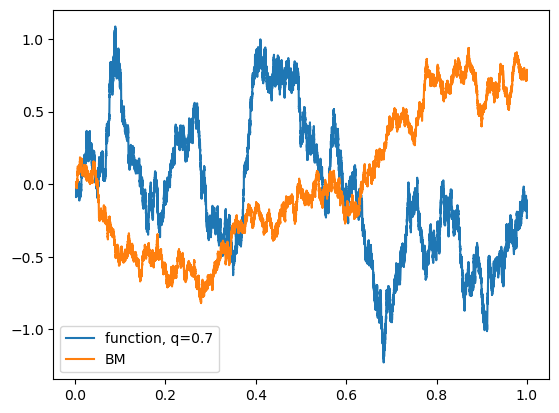

In [389]:
#Do simulation for special case f(x)=|x|^{q-1}x

#Comupte Euler-Maruyama scheme

def sim_q(t0, q, gridpoints=100):
    # Time grid from t0 to 1
    grid = np.linspace(t0, 1, gridpoints)
    dt = (1 - t0) / (gridpoints - 1)
    
    # Brownian increments
    dB = np.random.normal(loc=0, scale=np.sqrt(dt), size=gridpoints - 1)

    # Initial condition from N(0, t0)
    x = np.zeros(gridpoints)
    x[0] = np.random.normal(loc=0, scale=np.sqrt(t0))
    
    # Precompute constants
    sqrt_2pi = np.sqrt(2 * np.pi)
    
    # Precompute sqrt(t) and 1/t values
    sqrt_grid = np.sqrt(grid)
    inv_grid = 1.0 / grid

    for j in range(1, gridpoints):
        t = grid[j-1]
        x_prev = x[j-1]
        
        # Compute density manually: norm.pdf(x_prev, 0, sqrt(t))
        rho = (1 / (sqrt_2pi * sqrt_grid[j-1])) * np.exp(-0.5 * x_prev**2 / t)

        drift = (-1)*q*(abs(rho))**(q-1)*np.sign(rho) * (x_prev / t)
        diffusion = np.sqrt(1+2*(abs(rho))**(q-1))
        
        x[j] = x_prev + drift * dt + diffusion * dB[j-1]

    
    return x

t0=0.001
gridpoints=100000
q=0.7
grid=np.linspace(2*t0, 1, gridpoints)
plt.plot(grid, sim_q(t0=t0, q=q, gridpoints=gridpoints), label=f'function, q={q}')
plt.plot(grid, sim(beta=1, gridpoints=gridpoints), label='BM')
plt.legend()
plt.show()


#plt.plot(grid, sim_q(t0, q, gridpoints), label=f'function, q={q}')
#plt.plot(grid, sim(beta=1, gridpoints=gridpoints), label='BM')
#plt.legend()
#plt.show()


We compute again the covariance.

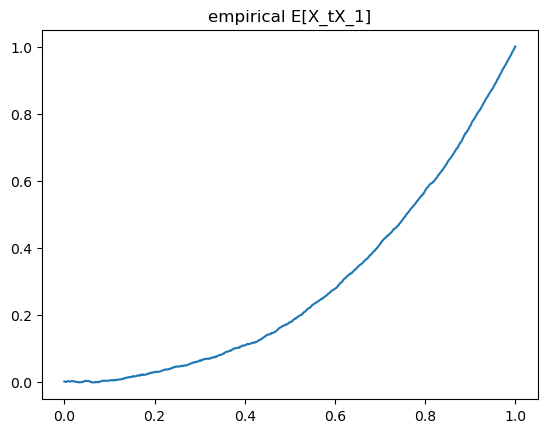

In [404]:
t0=0.01
gridpoints=1000
runs=10000
q=0.7

def covariance2(gridpoints, runs):
    cov=np.zeros(gridpoints)
    for _ in range(runs):
        path = sim_q(t0, q, gridpoints)
        for i in range(gridpoints):
            cov[i]=cov[i]+path[-1]*path[i]  # Value at t = 1
    return cov/runs

grid=np.linspace(0, 1, gridpoints)
plt.plot(grid, covariance2(gridpoints, runs))
#cov_theory=grid**((1+beta)/2)
#plt.plot(grid, cov_theory)
plt.title(f'empirical E[X_tX_1]')
plt.show()


We study again dependency of one realization on parameter q

In [483]:
t0=0.001
gridpoints=10000
dt = (1 - t0) / (gridpoints - 1)
start = np.random.normal(loc=0, scale=np.sqrt(t0))
dB = np.random.normal(loc=0, scale=np.sqrt(dt), size=gridpoints - 1)

def dependency_q(q):
    grid = np.linspace(t0, 1, gridpoints)
    
    
    # Brownian increments
    

    # Initial condition from N(0, t0)
    x = np.zeros(gridpoints)
    x[0]=start
    
    # Precompute constants
    sqrt_2pi = np.sqrt(2 * np.pi)
    
    # Precompute sqrt(t) and 1/t values
    sqrt_grid = np.sqrt(grid)
    inv_grid = 1.0 / grid

    for j in range(1, gridpoints):
        t = grid[j-1]
        x_prev = x[j-1]
        
        # Compute density manually: norm.pdf(x_prev, 0, sqrt(t))
        rho = (1 / (sqrt_2pi * sqrt_grid[j-1])) * np.exp(-0.5 * x_prev**2 / t)

        drift = (-1)*q*(abs(rho))**(q-1)*np.sign(rho) * (x_prev / t)
        diffusion = np.sqrt(1+2*(abs(rho))**(q-1))
        
        x[j] = x_prev + drift * dt + diffusion * dB[j-1]
    



    plt.plot(grid, x)
    plt.xlabel('t')
    plt.ylabel('X^q_t')
    plt.ylim(-1, 1)
    plt.title(f'Fixed realization X^q, q={round(q, 5)}')
    plt.show()
    return None


slider_q=widgets.FloatSlider(value=1, min=0.7, max=1.9, description='q', orientation='horizontal', layout=widgets.Layout(width='500px'), readout=True)

# Use interact to link the slider with the iteration function
interact(dependency_q, q=slider_q)

interactive(children=(FloatSlider(value=1.0, description='q', layout=Layout(width='500px'), max=1.9, min=0.7),…

<function __main__.dependency_q(q)>

We can even allow for a generic function and its derivative, satisfying the integrability conditions. As input, give a function and its derivative, sim_f computes the corresponding stochastic process. 

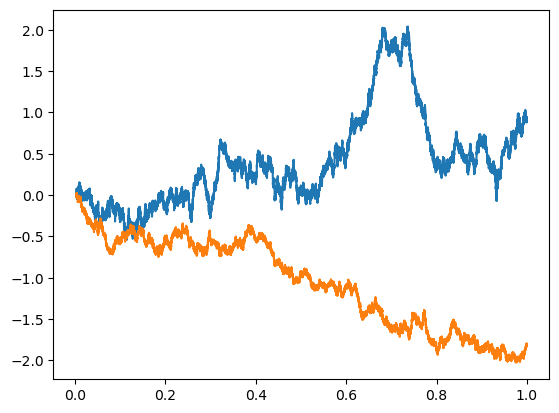

In [469]:
#General setting: Define function and its derivative
c=1
p=1.1
def func(x):
    return c*(abs(x))**(p-1)*x
def Dfunc(x):
    return c*p*(abs(x))**(p-2)*x
    
#Comupte Euler-Maruyama scheme

def sim_f(t0, f, Df, gridpoints=100):
    # Time grid from t0 to 1
    grid = np.linspace(t0, 1, gridpoints)
    dt = (1 - t0) / (gridpoints - 1)
    
    # Brownian increments
    dB = np.random.normal(loc=0, scale=np.sqrt(dt), size=gridpoints - 1)

    # Initial condition from N(0, t0)
    x = np.zeros(gridpoints)
    x[0] = np.random.normal(loc=0, scale=np.sqrt(t0))
    
    # Precompute constants
    sqrt_2pi = np.sqrt(2 * np.pi)
    
    # Precompute sqrt(t) and 1/t values
    sqrt_grid = np.sqrt(grid)
    inv_grid = 1.0 / grid

    for j in range(1, gridpoints):
        t = grid[j-1]
        x_prev = x[j-1]
        
        # Compute density manually: norm.pdf(x_prev, 0, sqrt(t))
        rho = (1 / (sqrt_2pi * sqrt_grid[j-1])) * np.exp(-0.5 * x_prev**2 / t)

        drift = -Df(rho) * (x_prev / t)
        diffusion = np.sqrt(1+2*(f(rho)/rho))
        
        x[j] = x_prev + drift * dt + diffusion * dB[j-1]

    return x

t0=0.001
gridpoints=100000
grid=np.linspace(2*t0, 1, gridpoints)

plt.plot(grid, sim_f(t0, func, Dfunc, gridpoints))
plt.plot(grid, sim(beta=1, gridpoints=gridpoints))
plt.show()

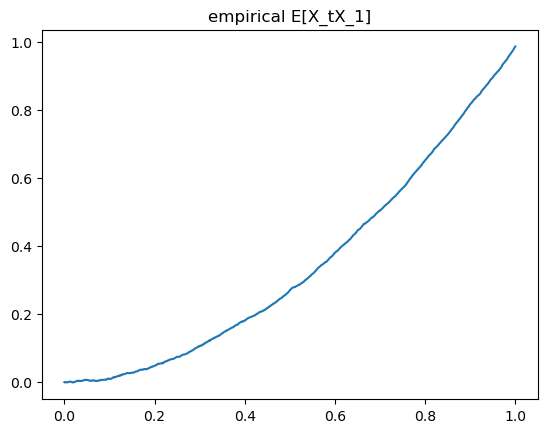

In [473]:
t0=0.01
gridpoints=1000
runs=10000


def covariance2(gridpoints, runs):
    cov=np.zeros(gridpoints)
    for _ in range(runs):
        path = sim_f(t0, func, Dfunc, gridpoints)
        for i in range(gridpoints):
            cov[i]=cov[i]+path[-1]*path[i]  # Value at t = 1
    return cov/runs

grid=np.linspace(0, 1, gridpoints)
plt.plot(grid, covariance2(gridpoints, runs))
#cov_theory=grid**((1+beta)/2)
#plt.plot(grid, cov_theory)
plt.title(f'empirical E[X_tX_1]')
plt.show()
